In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver
    
%load_ext autoreload
%autoreload 2

In [2]:
# uncomment if required to use default network
# from network import Network

class Network(object):
    def __init__(self):
        self.layers = None
        self.create_layers()

    def create_layers(self):
        self.layers = []
        self.layers.append(tf.layers.Dense(units=50, activation=tf.nn.relu))
        self.layers.append(tf.layers.Dense(units=10))

    def forward(self, x, apply_dropout, keep_prob_input=1.0, keep_prob_hidden=1.0):
        input_shape = np.prod(x.shape.as_list()[1:])
        x = tf.reshape(x, [-1, input_shape])
        if (apply_dropout):
            x = tf.nn.dropout(x, keep_prob_input)
        y = x
        for i in range(len(self.layers) - 1):
            y = self.layers[i](y)
            if (apply_dropout):
                y = tf.nn.dropout(y, keep_prob_hidden)
        y = self.layers[-1](y)
        return y

    def get_layer_variables(self):
        l = []
        for i in range(len(self.layers)):
            l.extend(self.layers[i].variables)
        return l
    def name(self):
        return 'fc50_fc10'

In [3]:
network = Network()

In [4]:
task_home = ''
if use_tpu:
    task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = './'
checkpoint_path = task_home + '80_20_logs/' + network.name() + '/checkpoints/'
summaries_path = task_home + '80_20_logs/'+ network.name() + '/summaries/'
data_path = task_home + 'MNIST_data/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 256

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
else:
    sess = tf.Session()

In [6]:
def read_split(split_path):
    split = []
    try:
        f = open(split_path)
        while (True):
            line = f.readline()
            if (line == ""):
                break
            split.append([float(i) for i in line.split()])
    except IOError:
        print("split path file not found")
        exit(-1)
    return split

from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

def split_mnist(mnist, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(mnist.train.labels, axis=1)
    validation_labels = np.argmax(mnist.validation.labels, axis=1)
    test_labels = np.argmax(mnist.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * mnist.train.images.shape[0]
        cur_validation_indices = [False] * mnist.validation.images.shape[0]
        cur_test_indices = [False] * mnist.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(mnist)
        task.train._images = task.train._images[cur_train_indices]
        task.train._labels = task.train._labels[cur_train_indices]
        task.validation._images = task.validation._images[cur_validation_indices]
        task.validation._labels = task.validation._labels[cur_validation_indices]
        task.test._images = task.test._images[cur_test_indices]
        task.test._labels = task.test._labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list

def read_datasets():
    split = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
    mnist = read_data_sets(data_path, one_hot=True)
    seed = 1
    task_list = split_mnist(mnist, split, seed)
    return split, task_list


    

In [7]:
input_shape = (28 * 28, )
output_shape = (10, )

In [8]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            read_datasets=read_datasets, load_best_hparams=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [9]:
# task 0
t = 0
seed = 0
np.random.seed(0)
learning_rates = list(np.logspace(-3.7, -1.1, 10))
# learning_rates = list(np.random.uniform(1e-4, 1e-3, (10, )))
fisher_multipliers = [0.0]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.8, 0.9, 1.0]
prod = list(itertools.product(fisher_multipliers, dropout_input_probs, dropout_hidden_probs, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['fisher_multiplier'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['learning_rate'] = hparams_tuple[3]
    hparams.append(cur_dict)
tuner.hparams_list[t] = hparams

In [ ]:
best_avg, best_hparams = tuner.tune_on_task(t, BATCH_SIZE)

Training with dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00019952623149688788,task=0
epochs: 44.859813, final train loss: 0.187819, validation accuracies: [0.9672]
best epochs: 42.523364, best_avg: 0.967400, validation accuracies: [0.9674]
saving model dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00019952623149688788,task=0 at time step 9600
Training with dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00038805107322101794,task=0
epochs: 34.579439, final train loss: 0.091195, validation accuracies: [0.9704]
best epochs: 32.242991, best_avg: 0.970800, validation accuracies: [0.9708]
saving model dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00038805107322101794,task=0 at time step 7400
Training with dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.0007547059566968904,task=0
epochs: 27.102804, fin

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.07943282347242814,task=0 at time step 1200
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00019952623149688788,task=0
epochs: 31.308411, final train loss: 0.204787, validation accuracies: [0.9578]
best epochs: 28.971963, best_avg: 0.958000, validation accuracies: [0.958]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00019952623149688788,task=0 at time step 6700
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00038805107322101794,task=0
epochs: 31.775701, final train loss: 0.100118, validation accuracies: [0.9684]
best epochs: 29.439252, best_avg: 0.969200, validation accuracies: [0.9692]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00038805107322101794,task=0 at time step 6800
Training

In [11]:
print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 32
print(tuner.validation_accuracy(t, VALIDATION_BATCH_SIZE))

0.9814494252204895 {'learning_rate': 0.003981071705534969, 'fisher_multiplier': 0.0, 'dropout_input_prob': 1.0, 'dropout_hidden_prob': 1.0}
INFO:tensorflow:Restoring parameters from ./80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.003981071705534969,task=0.ckpt-1500
[0.9796626984126984]


In [12]:
# task 1
t = 1
seed = 0
np.random.seed(0)
learning_rates = [5e-6]
fisher_multipliers = np.logspace(2, 7, 51)
dropout_input_probs = [1.0]
dropout_hidden_probs = [1.0]
prod = list(itertools.product(learning_rates, fisher_multipliers, dropout_input_probs, dropout_hidden_probs))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['learning_rate'] = hparams_tuple[0]
    cur_dict['fisher_multiplier'] = hparams_tuple[1]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[3]
    hparams.append(cur_dict)
tuner.hparams_list[t] = hparams

In [13]:
best_avg, best_hparams = tuner.tune_on_task(t, BATCH_SIZE)

Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=100.0,learning_rate=5e-06,task=1
Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0.ckpt-4200
epochs: 304.761905, final train loss: 0.185179, validation accuracies: [0.91417265 0.9285714 ]
best epochs: 266.666667, best_avg: 0.925521, validation accuracies: [0.9356913  0.84415585]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=100.0,learning_rate=5e-06,task=1 at time step 6400
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=125.89254117941675,learning_rate=5e-06,task=1
Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,f

Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0.ckpt-4200
epochs: 438.095238, final train loss: 0.300975, validation accuracies: [0.9408855  0.94588745]
best epochs: 419.047619, best_avg: 0.941798, validation accuracies: [0.9423695  0.93722945]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=1000.0,learning_rate=5e-06,task=1 at time step 9200
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=1258.9254117941675,learning_rate=5e-06,task=1
Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0
INFO:tensorflow:Restoring parameters from gs:/

Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0.ckpt-4200
epochs: 1833.333333, final train loss: 0.191807, validation accuracies: [0.92752904 0.93073595]
best epochs: 1361.904762, best_avg: 0.952261, validation accuracies: [0.9668563  0.83549786]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=10000.0,learning_rate=5e-06,task=1 at time step 38500
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=12589.254117941662,learning_rate=5e-06,task=1
Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0
INFO:tensorflow:Restoring parameters from 

Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0.ckpt-4200
epochs: 2095.238095, final train loss: 0.218776, validation accuracies: [0.8869651 0.8982684]
best epochs: 1771.428571, best_avg: 0.933757, validation accuracies: [0.9609201 0.7164502]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=100000.0,learning_rate=5e-06,task=1 at time step 44000
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=125892.54117941661,learning_rate=5e-06,task=1
Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0
INFO:tensorflow:Restoring parameters from gs:

Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0.ckpt-4200
epochs: 2119.047619, final train loss: 0.369300, validation accuracies: [0.8842444 0.8852814]
best epochs: 1819.047619, best_avg: 0.924199, validation accuracies: [0.9601781 0.6363636]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=1000000.0,learning_rate=5e-06,task=1 at time step 44500
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=1258925.4117941686,learning_rate=5e-06,task=1
Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0
INFO:tensorflow:Restoring parameters from gs

Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0.ckpt-4200
epochs: 2123.809524, final train loss: 0.316888, validation accuracies: [0.8842444 0.8852814]
best epochs: 1823.809524, best_avg: 0.923457, validation accuracies: [0.96042544 0.62770563]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=10000000.0,learning_rate=5e-06,task=1 at time step 44600
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=3162.2776601683795,learning_rate=5e-06,task=1
Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.01,learning_rate=0.0009672964844509264,task=0
INFO:tensorflow:Restoring parameters from

In [14]:
print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 32
print(tuner.validation_accuracy(t, VALIDATION_BATCH_SIZE))

0.9570781389872233 {'learning_rate': 5e-06, 'fisher_multiplier': 3162.2776601683795, 'dropout_input_prob': 1.0, 'dropout_hidden_prob': 1.0}
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=3162.2776601683795,learning_rate=5e-06,task=1.ckpt-18500
[0.9640376984126984, 0.9017857142857143]


In [10]:
# task 2
t = 2
seed = 0
np.random.seed(0)
learning_rates = [5e-6]
fisher_multipliers = np.logspace(2, 7, 51)
dropout_input_probs = [1.0]
dropout_hidden_probs = [1.0]
prod = list(itertools.product(learning_rates, fisher_multipliers, dropout_input_probs, dropout_hidden_probs))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['learning_rate'] = hparams_tuple[0]
    cur_dict['fisher_multiplier'] = hparams_tuple[1]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[3]
    hparams.append(cur_dict)
tuner.hparams_list[t] = hparams

In [11]:
best_avg, best_hparams = tuner.tune_on_task(t, BATCH_SIZE)

Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=100.0,learning_rate=5e-06,task=2
Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=3162.2776601683795,learning_rate=5e-06,task=1
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=3162.2776601683795,learning_rate=5e-06,task=1.ckpt-18500
epochs: 442.857143, final train loss: 0.768008, validation accuracies: [0.82537717 0.15584415 0.83838385]
best epochs: 0.000000, best_avg: 0.861370, validation accuracies: [0.9638882 0.9025974 0.       ]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=100.0,learning_rate=5e-06,task=2 at time step 9300
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=125.89254117941675,learning_rate=5e-06,task=2
Restoring paramters from dropout_hidden_prob=1.0,dropout_in

saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=794.3282347242813,learning_rate=5e-06,task=2 at time step 36800
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=1000.0,learning_rate=5e-06,task=2
Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=3162.2776601683795,learning_rate=5e-06,task=1
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=3162.2776601683795,learning_rate=5e-06,task=1.ckpt-18500
epochs: 1866.666667, final train loss: 0.390574, validation accuracies: [0.87558746 0.75108224 0.8828283 ]
best epochs: 1652.380952, best_avg: 0.870048, validation accuracies: [0.8904279 0.7467533 0.830303 ]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=1000.0,learning_rate=5e-06,task=2 at time step 39200
Training with dropout_hidden_prob=1

epochs: 2414.285714, final train loss: 0.331666, validation accuracies: [0.85753155 0.63852817 0.8606061 ]
best epochs: 2019.047619, best_avg: 0.895084, validation accuracies: [0.93692803 0.86147183 0.5939394 ]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=7943.282347242822,learning_rate=5e-06,task=2 at time step 50700
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=10000.0,learning_rate=5e-06,task=2
Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=3162.2776601683795,learning_rate=5e-06,task=1
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=3162.2776601683795,learning_rate=5e-06,task=1.ckpt-18500
epochs: 2442.857143, final train loss: 0.388452, validation accuracies: [0.84986395 0.6168831  0.8545455 ]
best epochs: 2047.619048, best_avg: 0.893865, validatio

KeyboardInterrupt: 

In [13]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 32
print(tuner.validation_accuracy(t, VALIDATION_BATCH_SIZE))

INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=3162.2776601683795,learning_rate=5e-06,task=2.ckpt-47900
[0.8700396825396826, 0.7276785714285714, 0.875]


In [14]:
# tuner.load_results_list()
tuner.save_best_hparams()

cur_best_avg: 8.956354e-01, num_updates: 40600
best val_acc: [0.92208755 0.84632033 0.73333335]


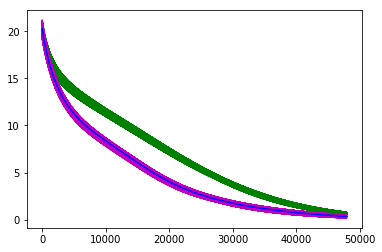

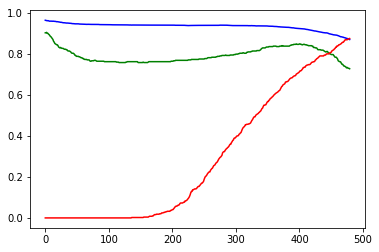

In [16]:
# print("best_avg: %e, best_params: %s" % (best_avg, str(best_params)))
# print("best_params: dropout: %f, fisher_multiplier: %e, lr: %e" % best_params)

# for k, v in tuner.results_list.items():
best_avg_tuple = tuple([v for k, v in sorted(tuner.best_hparams[t][0].items())])
cur_res = tuner.results_list[t][best_avg_tuple]
# cur_res = v
x = np.arange(0, len(cur_res['loss']), tuner.eval_frequency)
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, cur_best_avg_updates // tuner.eval_frequency])))
plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
plt.plot(cur_res['val_acc'][0], color='b')
plt.plot(cur_res['val_acc'][1], color='g')
plt.plot(cur_res['val_acc'][2], color='r')

plt.show()

In [17]:
def get_confusion_matrix(tuner):
    num_labels = 10
    pred = np.array([])
    actual = np.array([])
    for j in range(t + 1):
        val_data = tuner.task_list[j].validation
        feed_dict = tuner.classifier.create_feed_dict(val_data.images, val_data.labels, keep_input=1.0, keep_hidden=1.0)
        cur_scores, cur_y = tuner.classifier.get_predictions(sess, feed_dict)
        cur_pred = np.argmax(cur_scores, 1)
        cur_actual = np.argmax(cur_y, 1)
        actual = np.concatenate([actual, cur_actual])
        pred = np.concatenate([pred, cur_pred])
    confusion_matrix = np.zeros((num_labels,num_labels), dtype=np.int64)

    for i in range(actual.shape[0]):
        confusion_matrix[int(actual[i]), int(pred[i])] += 1
    return confusion_matrix

def print_confusion_matrix(confusion_matrix):
    print("%3d" % (0, ), end=' ')
    for j in range(confusion_matrix.shape[1]):
        print("%3d" % (j, ), end=' ')
    print("")
    for i in range(confusion_matrix.shape[0]):
        print("%3d" % (i, ), end=' ')
        for j in range(confusion_matrix.shape[1]):
            print("%3d" % (confusion_matrix[i][j], ), end= ' ')
        print("")

In [11]:
# confusion matrix before training
# train on best hyperparameters

# best_params = (1.0, 10 ** (18 / 19 + 4), 5e-6)
# best_num_updates = 3600

dropout, fisher_multiplier, lr = best_params
best_num_updates = result[best_params]['best_avg'][1]

model_name = tuner.file_name(lr, fisher_multiplier, t)
tuner.classifier.prepare_for_training(sess=tuner.sess, 
                                    model_name=model_name, 
                                    model_init_name=model_init_name, 
                                    fisher_multiplier=fisher_multiplier, 
                                    learning_rate=lr)

confusion_matrix = get_confusion_matrix(tuner)
print_confusion_matrix(confusion_matrix)


INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00077,multiplier=1291.96,mbsize=250,epochs=10,perm=0.ckpt-1759
  0   0   1   2   3   4   5   6   7   8   9 
  0 474   0   0   1   0   2   0   2   0   0 
  1   0 560   0   0   1   0   0   2   0   0 
  2   0   4 481   0   0   1   0   2   0   0 
  3   0   0   2 483   1   5   0   2   0   0 
  4   0   1   0   0 532   0   0   2   0   0 
  5   0   1   1   2   1 428   1   0   0   0 
  6   2   1   1   0   4   3 489   1   0   0 
  7   0   1   1   0   3   0   0 545   0   0 
  8   8  39  59 212  22 108   6   8   0   0 
  9   0   0   0   0   0   0   0   0   0   0 


In [10]:
# train on best hyperparameters
# dropout, fisher_multiplier, lr = best_params
dropout, fisher_multiplier, lr = (1.0, 10 ** (4 + 17 * 3 / 29), 5e-6)
best_num_updates = 1300
print("dropout: %f, fisher_multiplier: %e, lr: %e" % (dropout, fisher_multiplier, lr))
start_time = time.time()
model_name = tuner.file_name(lr, fisher_multiplier, t)
val_acc, val_loss, loss, loss_with_penalty, cur_best_avg, cur_best_avg_num_updates = train(lr, t, dropout_input, dropout, model_init_name, fisher_multiplier, best_num_updates)
# cur_params = (dropout, fisher_multiplier, lr)
# result[cur_params] = {}
# result[cur_params]["val_acc"] = val_acc
# result[cur_params]["val_loss"] = val_loss
# result[cur_params]["loss"] = loss
# result[cur_params]["loss_with_penalty"] = loss_with_penalty
# result[cur_params]["best_avg"] = (cur_best_avg, cur_best_avg_num_updates)
print("time taken: %f" % (time.time() - start_time))
print("loss with penalty: %f, loss: %f, val0 accuracy: %f, val1 accuracy: %f"
      % (loss_with_penalty[-1], loss[-1], 
         val_acc[0][cur_best_avg_num_updates // eval_frequency], val_acc[1][cur_best_avg_num_updates // eval_frequency]))

tuner.classifier.update_fisher_full_batch(sess, dataset_train)
tuner.classifier.save_weights(best_num_updates, tuner.sess, model_name)
tuner.best_parameters.append((lr, fisher_multiplier, model_name))

dropout: 1.000000, fisher_multiplier: 5.736153e+05, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00069,multiplier=1453.79,mbsize=250,epochs=10,perm=0.ckpt-1759
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00069,multiplier=1453.79,mbsize=250,epochs=10,perm=0.ckpt-1759
time taken: 36.348515
loss with penalty: 1.455915, loss: 0.449977, val0 accuracy: 0.973040, val1 accuracy: 0.900433
saving model layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1 at time step 1300


In [12]:
# task2
t = 2
dataset_train = tuner.task_list[t].train
dataset_lagged = tuner.task_list[t - 1].train if t > 0 else None
# model_init_name = tuner.best_parameters[t - 1][2] if t > 0 else None
model_init_name = 'layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1'
MINI_BATCH_SIZE = 256
LOG_FREQUENCY = 100
dataset_train.initialize_iterator(MINI_BATCH_SIZE)
if (dataset_lagged is not None):
    dataset_lagged.initialize_iterator(MINI_BATCH_SIZE)

eval_frequency = 100
dropout_input = 1.0
result_2 = {}

In [13]:
num_updates = 5000
# dropouts = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
dropouts = [1.0]
fisher_multipliers = np.logspace(2, 7, 50)
# fisher_multipliers = [0.0]
learning_rates = [5e-6]
best_avg = 0.0
best_params = -1
best_num_updates = -1
for dropout in dropouts:
    for fisher_multiplier in fisher_multipliers:
        for lr in learning_rates:
            print("dropout: %f, fisher_multiplier: %e, lr: %e" % (dropout, fisher_multiplier, lr))
            start_time = time.time()
            val_acc, val_loss, loss, loss_with_penalty, cur_best_avg, cur_best_avg_num_updates = train(lr, t, dropout_input, dropout, model_init_name, fisher_multiplier)
        cur_params = (dropout, fisher_multiplier, lr)
        result_2[cur_params] = {}
        result_2[cur_params]["val_acc"] = val_acc
        result_2[cur_params]["val_loss"] = val_loss
        result_2[cur_params]["loss"] = loss
        result_2[cur_params]["loss_with_penalty"] = loss_with_penalty
        result_2[cur_params]["best_avg"] = (cur_best_avg, cur_best_avg_num_updates)
        if (best_avg < cur_best_avg):
            best_avg = cur_best_avg
            best_params = cur_params
            best_num_updates = cur_best_avg_num_updates
        print("time taken: %f" % (time.time() - start_time))
        print("loss with penalty: %f, loss: %f, val0 accuracy: %f, val1 accuracy: %f, val2 accuracy: %f"
              % (loss_with_penalty[-1], loss[-1], 
                 val_acc[0][cur_best_avg_num_updates // eval_frequency], val_acc[1][cur_best_avg_num_updates // eval_frequency], val_acc[2][cur_best_avg_num_updates // eval_frequency]))

dropout: 1.000000, fisher_multiplier: 1.000000e+02, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 23.703945
loss with penalty: 0.165240, loss: 0.079856, val0 accuracy: 0.968835, val1 accuracy: 0.478355, val2 accuracy: 0.735354
dropout: 1.000000, fisher_multiplier: 1.264855e+02, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 24.908948
loss with penalty: 0.162454, loss: 0.059935, val0 accuracy: 0.968835, val1 accuracy: 0.480519, val2 accuracy: 0.735354
dropout: 1.000000, fisher_multiplier: 1.599859e+02, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoint

INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 50.275783
loss with penalty: 1.477962, loss: 0.341894, val0 accuracy: 0.961167, val1 accuracy: 0.803030, val2 accuracy: 0.901010
dropout: 1.000000, fisher_multiplier: 1.389495e+04, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 46.886580
loss with penalty: 1.645556, loss: 0.360029, val0 accuracy: 0.962899, val1 accuracy: 0.829004, val2 accuracy: 0.876768
dropout: 1.000000, fisher_multiplier: 1.757511e+04, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epoc

INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 20.514503
loss with penalty: 13.439526, loss: 12.901023, val0 accuracy: 0.972050, val1 accuracy: 0.915584, val2 accuracy: 0.000000
dropout: 1.000000, fisher_multiplier: 1.526418e+06, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 20.267411
loss with penalty: 14.109320, loss: 13.665174, val0 accuracy: 0.972050, val1 accuracy: 0.915584, val2 accuracy: 0.000000
dropout: 1.000000, fisher_multiplier: 1.930698e+06, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,

In [15]:
# train on best hyperparameters
dropout, fisher_multiplier, lr = best_params
# dropout, fisher_multiplier, lr = (1.0, 10 ** (4 + 17 * 3 / 29), 5e-6)
# best_num_updates = 1300
print("dropout: %f, fisher_multiplier: %e, lr: %e" % (dropout, fisher_multiplier, lr))
start_time = time.time()
model_name = tuner.file_name(lr, fisher_multiplier, t)
val_acc, val_loss, loss, loss_with_penalty, cur_best_avg, cur_best_avg_num_updates = train(lr, t, dropout_input, dropout, model_init_name, fisher_multiplier, best_num_updates)
# cur_params = (dropout, fisher_multiplier, lr)
# result[cur_params] = {}
# result[cur_params]["val_acc"] = val_acc
# result[cur_params]["val_loss"] = val_loss
# result[cur_params]["loss"] = loss
# result[cur_params]["loss_with_penalty"] = loss_with_penalty
# result[cur_params]["best_avg"] = (cur_best_avg, cur_best_avg_num_updates)
print("time taken: %f" % (time.time() - start_time))
print("loss with penalty: %f, loss: %f, val0 accuracy: %f, val1 accuracy: %f, val2 accuracy: %f"
      % (loss_with_penalty[-1], loss[-1], 
         val_acc[0][cur_best_avg_num_updates // eval_frequency], val_acc[1][cur_best_avg_num_updates // eval_frequency], val_acc[2][cur_best_avg_num_updates // eval_frequency]))

tuner.classifier.update_fisher_full_batch(sess, dataset_train)
tuner.classifier.save_weights(best_num_updates, tuner.sess, model_name)
tuner.best_parameters.append((lr, fisher_multiplier, model_name))

dropout: 1.000000, fisher_multiplier: 1.757511e+04, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 32.221372
loss with penalty: 2.306470, loss: 0.514236, val0 accuracy: 0.968835, val1 accuracy: 0.833333, val2 accuracy: 0.826263
saving model layers=2,hidden=500,lr=0.00001,multiplier=17575.11,mbsize=250,epochs=10,perm=2 at time step 1900


In [18]:
# confusion matrix 
# finding which digits are being confused by classifier
confusion_matrix = get_confusion_matrix(tuner)
print_confusion_matrix(confusion_matrix)

  0   0   1   2   3   4   5   6   7   8   9 
  0 476   0   0   0   0   0   0   0   2   1 
  1   0 552   2   1   0   0   0   1   7   0 
  2   2   3 477   0   0   0   0   1   4   1 
  3   0   1   6 469   0   4   0   2   9   2 
  4   0   1   4   0 508   1   2   2   2  15 
  5   0   2   1   1   0 421   4   0   2   3 
  6   6   1   0   0   0   2 487   0   4   1 
  7   1   0   4   0   0   0   0 526   3  16 
  8   4   7  16  19   0  20   3   0 388   5 
  9   6   2   0   7  32   5   1  20   9 413 


In [19]:
# test accuracy
for j in range(t + 1):
    test_data = tuner.task_list[j].test
    feed_dict = tuner.classifier.create_feed_dict(test_data.images, test_data.labels, keep_input=1.0, keep_hidden=1.0)
    accuracy = sess.run([tuner.classifier.loss, tuner.classifier.accuracy], feed_dict=feed_dict)
    print(accuracy)

[0.12978701, 0.9642011]
[0.53868216, 0.8110883]
[0.5814527, 0.82160556]


In [17]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()